#Facenet

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install facenet_pytorch mtcnn

     |████████████████████████████████| 1.9 MB 5.1 MB/s 
     |████████████████████████████████| 2.3 MB 32.5 MB/s 


In [ ]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from PIL import Image
import cv2
from mtcnn.mtcnn import MTCNN as mt
from google.colab.patches import cv2_imshow

In [ ]:
mtcnn = MTCNN(image_size=240, margin=0, min_face_size=20) # initializing mtcnn for face detection
resnet = InceptionResnetV1(pretrained='vggface2').eval() # initializing resnet for face img to embeding conversion

dataset=datasets.ImageFolder('/content/drive/MyDrive/attendence_system/data/train') # photos folder path 
idx_to_class = {i:c for c,i in dataset.class_to_idx.items()} # accessing names of peoples from folder names

def collate_fn(x):
    return x[0]

loader = DataLoader(dataset, collate_fn=collate_fn)

face_list = [] # list of cropped faces from photos folder
name_list = [] # list of names corrospoing to cropped photos
embedding_list = [] # list of embeding matrix after conversion from cropped faces to embedding matrix using resnet

for img, idx in loader:
    face, prob = mtcnn(img, return_prob=True) 
    if face is not None and prob>0.90: # if face detected and porbability > 90%
        emb = resnet(face.unsqueeze(0)) # passing cropped face into resnet model to get embedding matrix
        embedding_list.append(emb.detach()) # resulten embedding matrix is stored in a list
        name_list.append(idx_to_class[idx]) # names are stored in a list


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [ ]:
data = [embedding_list, name_list]
torch.save(data, '/content/drive/MyDrive/attendence_system/data.pt') 

In [ ]:
def bbox(img, result):
  detector= mt()
  faces= detector.detect_faces(img)
  
  for i in range(0, len(faces)):
    [x,y,w,h] = faces[i]['box']
    cv2.rectangle(img, (x,y),(x+w,y+h),(0,255,0),2)
    cv2.putText(img, '{} : {:.2f}'.format(result[0],result[1]), (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 2)  
  img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  cv2_imshow(img)

Face matched with:  0000264 With distance:  0.8438443541526794


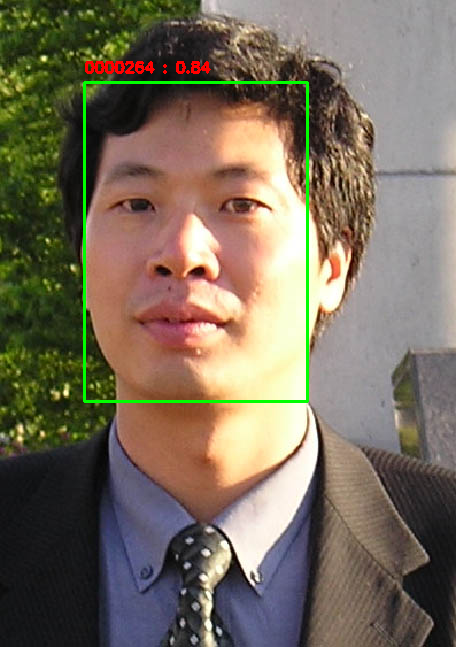

In [ ]:
def face_match(img_path, data_path): # img_path= location of photo, data_path= location of data.pt 
    # getting embedding matrix of the given img
    img = Image.open(img_path)
    face, prob = mtcnn(img, return_prob=True) # returns cropped face and probability
    emb = resnet(face.unsqueeze(0)).detach() # detach is to make required gradient false
    
    saved_data = torch.load('/content/drive/MyDrive/attendence_system/data.pt') # loading data.pt file
    embedding_list = saved_data[0] # getting embedding data
    name_list = saved_data[1] # getting list of names
    dist_list = [] # list of matched distances, minimum distance is used to identify the person
    
    for idx, emb_db in enumerate(embedding_list):
        dist = torch.dist(emb, emb_db).item()
        dist_list.append(dist)
        
    idx_min = dist_list.index(min(dist_list))
    return (name_list[idx_min], min(dist_list))

img_path= '/content/drive/MyDrive/attendence_system/data/test/0000268/0000005.jpg'
image= cv2.imread(img_path)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = face_match(img_path, '/content/drive/MyDrive/attendence_system/data.pt')

print('Face matched with: ',result[0], 'With distance: ',result[1])
bbox(image, result)